# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [228]:
import pandas as pd
df = pd.read_csv('texts.csv')
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [275]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';', decimal=b',')
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,133.43,132.60,133.90,132.00,16037970
1,07.12.2017,133.70,133.02,133.87,132.81,18198430
2,06.12.2017,133.33,134.00,134.29,132.91,14641730
3,05.12.2017,133.48,133.65,133.99,132.78,12684800
4,04.12.2017,133.01,133.77,134.00,131.93,17818980


In [276]:
pr_all.dropna(inplace=True)
pr_all.rename( columns={"Date": "date"}, inplace= True)
pr_all.date = pd.to_datetime(pr_all.date, dayfirst=True, errors='coerce')

    
#pr_all.Open.astype(int)
#pr_all.ClosingPrice.astype(int)
#pr_all.DailyHigh.astype(int)
#pr_all.DailyLow.astype(int)    
     


In [277]:

pr_all.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1987
Data columns (total 6 columns):
date            1964 non-null datetime64[ns]
Open            1964 non-null float64
ClosingPrice    1964 non-null float64
DailyHigh       1964 non-null float64
DailyLow        1964 non-null float64
VolumePcs       1964 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 107.4 KB


In [279]:
df.date = pd.to_datetime(df.date, dayfirst=True, errors='coerce')
df.dropna(inplace=True)
df.head()

,date,text
0,2017-11-09,Компания рассчитывает на решение по газовому с...
1,2017-11-08,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,2017-11-01,Новая редакция американских санкций ставит по...
3,2017-10-30,"Как стало известно “Ъ”, известный на рынке ри..."
4,2017-10-23,"НОВАТЭК, который через пять лет собирается за..."


In [280]:
all_data = df.merge(pr_all, on='date', how='left', sort=False)
all_data = all_data.dropna()
print(all_data.info())
all_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 0 to 1201
Data columns (total 7 columns):
date            1145 non-null datetime64[ns]
text            1145 non-null object
Open            1145 non-null float64
ClosingPrice    1145 non-null float64
DailyHigh       1145 non-null float64
DailyLow        1145 non-null float64
VolumePcs       1145 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 71.6+ KB
None


,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,2017-11-09,Компания рассчитывает на решение по газовому с...,132.31,131.50,132.82,131.14,33869650.0
1,2017-11-08,"Как и предполагал “Ъ”, «Газпром», воспользова...",132.00,132.30,133.94,131.58,39381960.0
2,2017-11-01,Новая редакция американских санкций ставит по...,126.40,126.50,126.89,125.97,18232550.0
3,2017-10-30,"Как стало известно “Ъ”, известный на рынке ри...",125.96,125.98,126.93,125.53,19263340.0
4,2017-10-23,"НОВАТЭК, который через пять лет собирается за...",127.05,126.80,127.47,126.37,17308800.0


### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

In [287]:
# Токинезация  и приведение к нижнему регистру
import re
regex = re.compile("[А-Яа-я----]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


all_data.text = all_data.text.str.lower()
all_data.text = all_data.text.apply(words_only)

In [288]:
all_data.text.iloc[6]

'газпром может подписать контракт со словенией на поставки газа на ближайшие пять лет в конце текущего начале следующего годов его условия стороны обсуждают уже несколько месяцев но не торопятся с заключением последний раз условия соглашения пересматривались в году поставки в страну составляют около млрд кубометров'

In [289]:
# удаление стоп слов
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-', '-']

print(mystopwords)
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
all_data.text = all_data.text.apply(remove_stopwords)   

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [290]:
%%time
# Лематизация
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

In [291]:
# Удаление стоп-лемм
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

### Корреляция между средней длинной текста за день и ценой закрытия

In [292]:
from scipy.stats import spearmanr
import seaborn as sns


In [293]:
len_corr_price = pd.DataFrame({'length' : all_data.text.apply(len), 'price': all_data.ClosingPrice}) 


In [294]:
len_corr_price.describe()

,length,price
count,1145.000000,1145.000000
mean,630.148472,149.902969
std,447.017538,23.390248
min,67.000000,107.170000
25%,333.000000,135.770000
50%,483.000000,144.300000
75%,805.000000,156.690000
max,3257.000000,244.000000


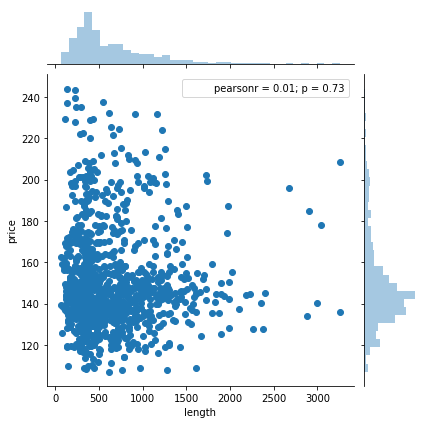

In [295]:
sns.jointplot(x='length', y='price', 
              data=len_corr_price, kind='scatter');

### Корреляция между количеством упоминаний Алексея Миллера и ценой закрытия.

In [299]:
import re

In [386]:
mill_corr_price = pd.DataFrame({'count' : all_data.text, 'price': all_data.ClosingPrice}) 

In [387]:
mill_corr_price.head()

,count,price
0,компания рассчитывает решение газовому спору у...,131.50
1,предполагал ъ газпром воспользовавшись жалобам...,132.30
2,новая редакция американских санкций ставит угр...,126.50
3,стало известно ъ известный рынке риск-менеджер...,125.98
4,новатэк который пять лет собирается запустить ...,126.80


In [407]:
prog = re.compile('миллер*')
l = []
for i, row in mill_corr_price.iterrows():
    l.append(len(prog.findall(row['count'])))
   
l
mill_corr_price['count'] = l

In [409]:
mill_corr_price.describe()

,count,price
count,1145.000000,1145.000000
mean,0.125764,149.902969
std,0.492860,23.390248
min,0.000000,107.170000
25%,0.000000,135.770000
50%,0.000000,144.300000
75%,0.000000,156.690000
max,6.000000,244.000000


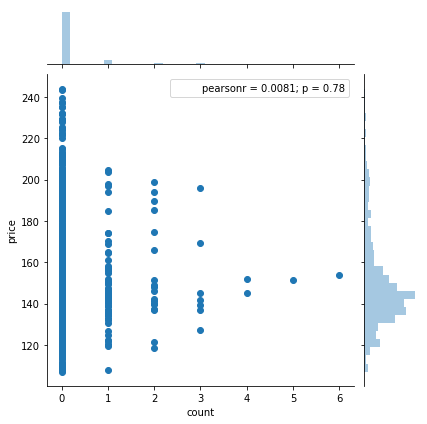

In [411]:
sns.jointplot(x='count', y='price', 
              data=mill_corr_price, kind='scatter');

### Упоминаний какого газопровода в статьях больше: 
"северный поток "турецкий поток"?

In [418]:
prog = re.compile('северный поток')
l = []
for i, row in all_data.iterrows():
    l.append(len(prog.findall(row['text'])))
sum (l)


10

In [419]:
prog = re.compile('турецкий поток')
l = []
for i, row in all_data.iterrows():
    l.append(len(prog.findall(row['text'])))
sum (l)

17

### Находим все прилагательные, стоящие перед словом "санкции"

In [420]:
import pandas as pd
df1 = pd.read_csv('texts.csv')
df1.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [426]:
s = ''
for i, row in df1.iterrows():
    s = s + row['text']

In [430]:
f = open('text.txt', 'w', encoding='utf-8')
f.write(s)


913414

In [ ]:
! chcp 65001
! type text.txt | docker run --rm -i inemo/syntaxnet_rus > data.conll

In [429]:
from nltk import DependencyGraph
import codecs

processed_sentences = []
sentence = []
for line in codecs.open('data.conll', 'r', 'utf-8'):
    if len(line) == 1:
        processed_sentences.append(sentence)
        sentence = []
    else:
        word = line.split("\t")
        sentence.append(word)

deps = []
for sentence in processed_sentences:
    s = u""
    for line in sentence:
        s += u"\t".join(line) + u'\n'
    deps.append(s)

for sent_dep in deps:
    graph = DependencyGraph(tree_str=sent_dep)
    for triple in graph.triples():
        for e in triple:
            print(e[0] if isinstance(e, tuple) else e,)
        print()
    print()
    tree = graph.tree()
    print(tree.pretty_print())

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xca in position 2: invalid continuation byte

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     